# Modeling Non-linear Pricing Elasiticity

The pricing elasticity curve, defined as by demand/quantity (y-axis) versus price (x-axis), is often modeled using linear models. However, we sometime observe that the pricing elasticity curve is curvilinear; namely, there is an exponential decay between quantity and price; as price goes up, quantity decays exponentially. Let's see how we can model the exponential decay relationship.

## Simulate price vs quantity

The exponential decay model is defined as follows.

$N(t) = N_0 e^{-\lambda t}$

Where,

- $t$ is time,
- $N_0$ is the starting amount at time zero, and
- $\lambda$ is the decay rate.

We will use the exponential decay to generate an exponential decay relationship between price and quantity. Below, we show some simulations where we add Gaussian noise.

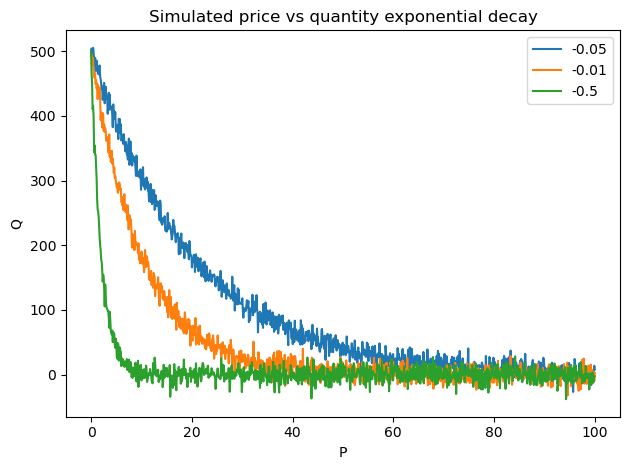

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(37)

def get_elasticity_curve(N_0=1, decay_rate=-0.05, n=1_000, start=0, end=100, std=0.01):
    x = np.linspace(start, end, n)
    y = (N_0 * np.exp(decay_rate * x)) + np.random.normal(0, std, len(x))

    return pd.Series(y, x)

fig, ax = plt.subplots()

get_elasticity_curve(N_0=500, decay_rate=-0.05, std=10).plot(kind='line', ax=ax, label='-0.05')
get_elasticity_curve(N_0=500, decay_rate=-0.1, std=10).plot(kind='line', ax=ax, label='-0.01')
get_elasticity_curve(N_0=500, decay_rate=-0.5, std=10).plot(kind='line', ax=ax, label='-0.5')

ax.set_xlabel('P')
ax.set_ylabel('Q')
ax.set_title('Simulated price vs quantity exponential decay')

ax.legend()

fig.tight_layout()

## Model price vs quantity

Let's simulate the elasticity curve with an exponential decay relationship between price and quantity. We will then use GAM to model the relationship between $P$ and $Q$.

In [30]:
from pygam import LinearGAM, s, f

def get_elasticity_curve_df(N_0=1, decay_rate=-0.05, n=1_000, start=0, end=100, std=0.01):
    return get_elasticity_curve(N_0, decay_rate, n, start, end, std) \
        .to_frame() \
        .reset_index() \
        .rename(columns={
            'index': 'P', 
            0: 'Q'
        })
    
Xy = get_elasticity_curve_df(N_0=500, std=10)
X = Xy[['P']]
y = Xy['Q']

pq_model = LinearGAM(s(0, n_splines=10)).fit(X, y)
pq_df = X.assign(Q=pq_model.predict(X))

You can see below that GAM does a very good job at smoothing the noisy relationship.

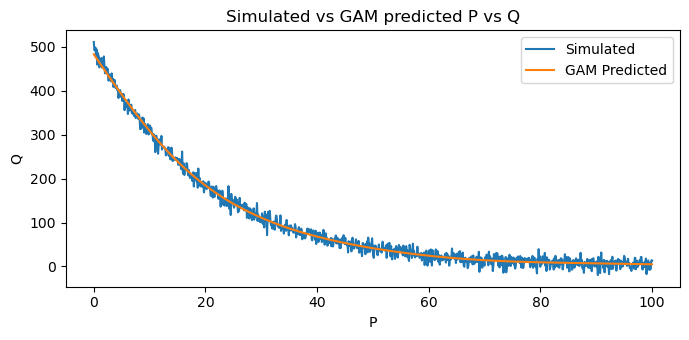

In [34]:
fig, ax = plt.subplots(figsize=(7, 3.5))

Xy.plot(kind='line', x='P', y='Q', ax=ax, label='Simulated')
pq_df.plot(kind='line', x='P', y='Q', ylabel='Q', ax=ax, label='GAM Predicted')

ax.set_title('Simulated vs GAM predicted P vs Q')

fig.tight_layout()

## Model quantity vs revenue

The revenue, $R$, is defined as $R = PQ$. We will use GAM to model the relationship between $Q$ and $R$.

In [35]:
Xy = pq_df.assign(R=lambda d: d['P'] * d['Q'])

X = Xy[['Q']]
y = Xy['R']

qr_model = LinearGAM(s(0, n_splines=10)).fit(X, y)
pqr_df = pq_df.assign(R=lambda d: qr_model.predict(d[['Q']]))

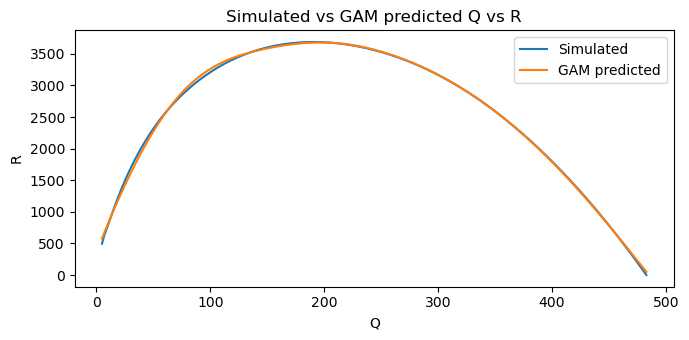

In [44]:
fig, ax = plt.subplots(figsize=(7, 3.5))

Xy.plot(kind='line', x='Q', y='R', ax=ax, label='Simulated')
pqr_df.plot(kind='line', x='Q', y='R', ylabel='R', ax=ax, label='GAM predicted')

ax.set_title('Simulated vs GAM predicted Q vs R')

fig.tight_layout()

## Marginal revenue

The marginal revenue, $R'$, is defined as follows.

$R' = \dfrac{\mathrm{d} R}{\mathrm{d} Q}$

In the linear model, we can analytically solve for $R'$ (also denoted as, MR). With a non-linear relationship, especially using GAM, we need to use numerical methods to estimate $R'$. Here, we use `numdifftools`.

In [8]:
%%time

import numdifftools as nd

dfun = nd.Gradient(lambda Q: qr_model.predict(pd.DataFrame(Q.reshape(-1,1), columns=['Q'])))
mr = np.array([dfun(v) for v in pqr_df['Q'].values])
pqrr_df = pqr_df.assign(MR=mr)

CPU times: user 10.2 s, sys: 29.1 ms, total: 10.2 s
Wall time: 10.3 s


Now we can plot $P, Q, R$ and $R'$.

- As $P$ goes up, $Q$ goes down
- As $P$ goes up, $R$ goes up and then down
- As $P$ goes up, $R'$ goes up
- As $Q$ goes up, $R$ goes up and then down
- As $Q$ goes up, $R'$ goes down
- As $R'$ goes up, $R$ goes up and then down

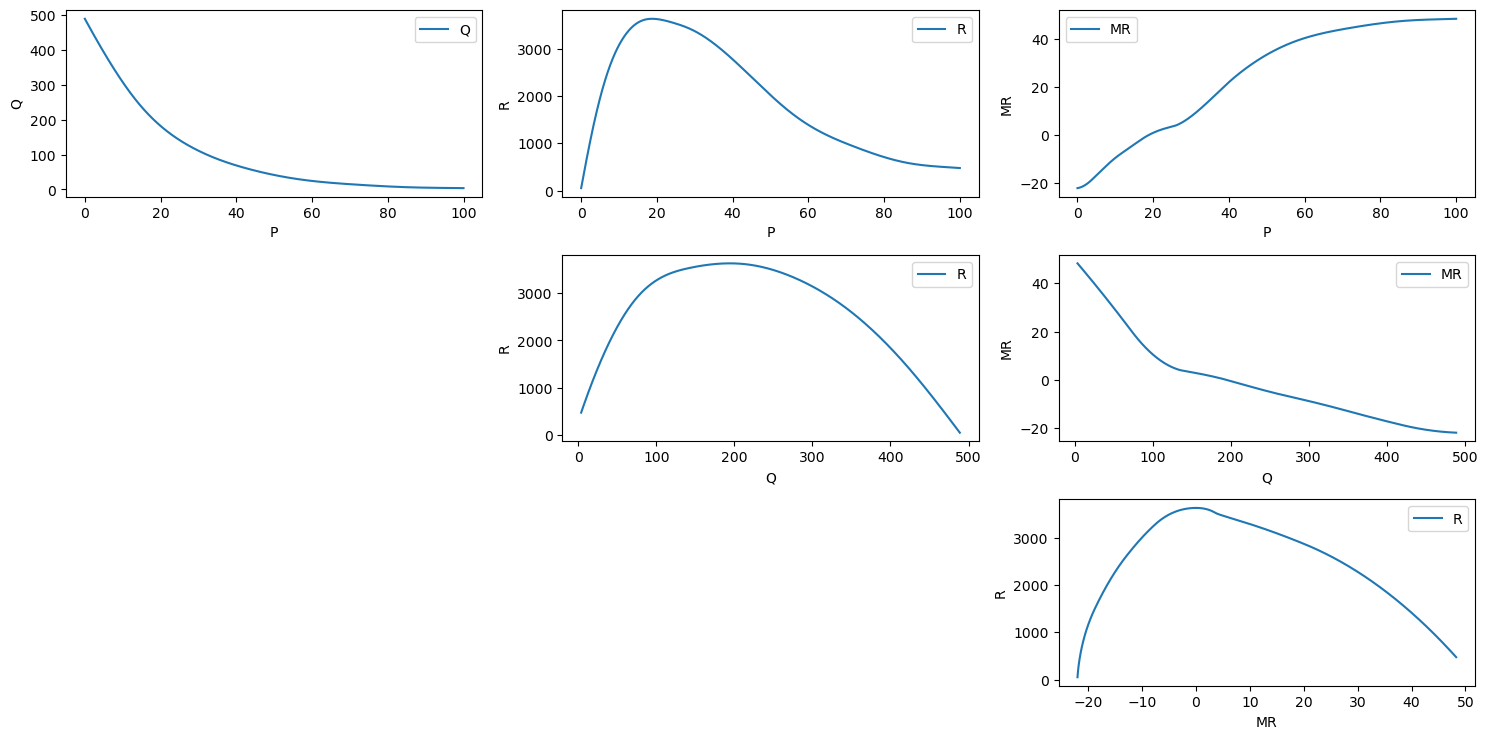

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(15, 7.5))
axes = np.ravel(axes)

pqrr_df.plot(kind='line', x='P', y='Q', ylabel='Q', ax=axes[0])
pqrr_df.plot(kind='line', x='P', y='R', ylabel='R', ax=axes[1])
pqrr_df.plot(kind='line', x='P', y='MR', ylabel='MR', ax=axes[2])
axes[3].axis('off')
pqrr_df.plot(kind='line', x='Q', y='R', ylabel='R', ax=axes[4])
pqrr_df.plot(kind='line', x='Q', y='MR', ylabel='MR', ax=axes[5])
axes[6].axis('off')
axes[7].axis('off')
pqrr_df.plot(kind='line', x='MR', y='R', ylabel='R', ax=axes[8])

fig.tight_layout()

## Optimal price

The optimal $R'$ is found when it is equal to the marginal cost, $C'$ (or MC). Let's say $C'$ is given as 20, then we can find the closest matching $R'$ and simply lookup the corresponding $R, Q,$ and $P$. According to the calculations, the optimal $P$ is 38.63, expected to sell $Q=73$ units, with a revenue of $R=2,870.97$.

In [52]:
pqrr_df \
    .assign(MC=20) \
    .assign(diff=lambda d: np.abs(d['MC'] - d['MR'])) \
    .sort_values(['diff']) \
    .head(5)

,P,Q,R,MR,MC,diff
386,38.638639,73.383914,2870.970368,20.016115,20,0.016115
385,38.538539,73.735715,2877.985594,19.865738,20,0.134262
387,38.738739,73.033705,2863.934233,20.166475,20,0.166475
384,38.438438,74.089122,2884.979680,19.715358,20,0.284642
388,38.838839,72.685076,2856.877481,20.316345,20,0.316345


Define the total cost as $C = C'Q$, then the profit, $T$ is defined as $T= PQ - C'Q$.

In [58]:
pqrr_df \
    .assign(MC=20) \
    .assign(diff=lambda d: np.abs(d['MC'] - d['MR'])) \
    .sort_values(['diff']) \
    .assign(C=lambda d: d['MC'] * d['Q']) \
    .assign(T=lambda d: d['R'] - d['C']) \
    .drop(columns=['diff']) \
    .head(5)

,P,Q,R,MR,MC,C,T
386,38.638639,73.383914,2870.970368,20.016115,20,1467.678282,1403.292086
385,38.538539,73.735715,2877.985594,19.865738,20,1474.714310,1403.271284
387,38.738739,73.033705,2863.934233,20.166475,20,1460.674101,1403.260132
384,38.438438,74.089122,2884.979680,19.715358,20,1481.782437,1403.197243
388,38.838839,72.685076,2856.877481,20.316345,20,1453.701513,1403.175967


In [60]:
pqrct_df = pqrr_df \
    .assign(MC=20) \
    .assign(C=lambda d: d['MC'] * d['Q']) \
    .assign(T=lambda d: d['R'] - d['C'])
pqrct_df

,P,Q,R,MR,MC,C,T
0,0.0000,488.882022,50.394511,-21.968368,20,9777.640441,-9727.245930
1,0.1001,486.895001,94.018082,-21.939546,20,9737.900029,-9643.881947
2,0.2002,484.910265,137.530696,-21.907096,20,9698.205305,-9560.674609
3,0.3003,482.927849,180.924531,-21.871031,20,9658.556983,-9477.632452
4,0.4004,480.947789,224.191824,-21.831366,20,9618.955777,-9394.763953
...,...,...,...,...,...,...,...
995,99.5996,3.832953,477.329433,48.253121,20,76.659067,400.670366
996,99.6997,3.821495,476.776521,48.257495,20,76.429906,400.346615
997,99.7998,3.809963,476.219975,48.261897,20,76.199260,400.020715
998,99.8999,3.798353,475.659636,48.266329,20,75.967063,399.692573


In [89]:
opt_s = pqrr_df \
    .assign(MC=20) \
    .assign(C=lambda d: d['MC'] * d['Q']) \
    .assign(T=lambda d: d['R'] - d['C']) \
    .assign(diff=lambda d: np.abs(d['MC'] - d['MR'])) \
    .sort_values(['diff']) \
    .head(1) \
    .iloc[0]
opt_s

P         38.638639
Q         73.383914
R       2870.970368
MR        20.016115
MC        20.000000
C       1467.678282
T       1403.292086
diff       0.016115
Name: 386, dtype: float64

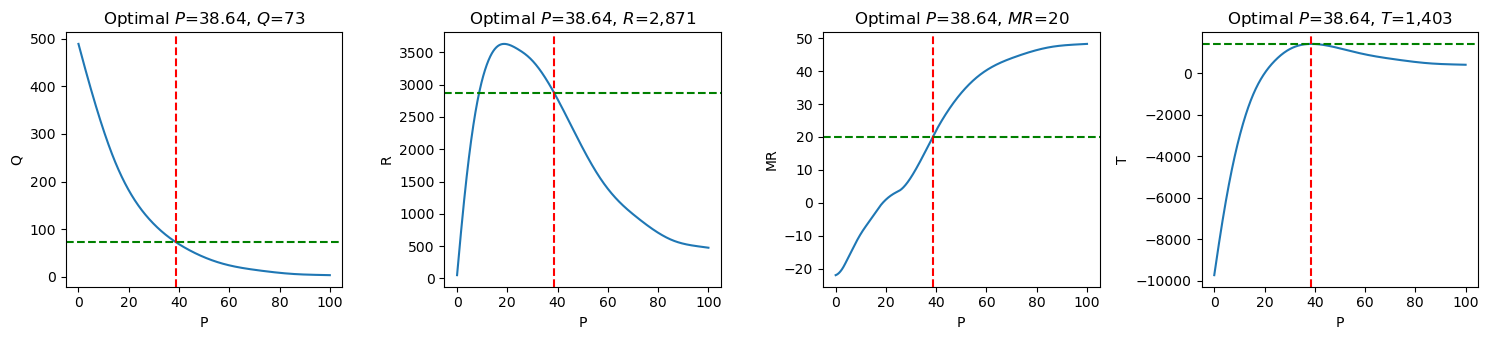

In [96]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

for y, _ax in zip(['Q', 'R', 'MR', 'T'], ax):
    pqrct_df.plot(kind='line', x='P', y=y, ax=_ax)
    _ax.axvline(x=opt_s['P'], color='r', linestyle='--')
    _ax.axhline(y=opt_s[y], color='g', linestyle='--')
    _ax.set_ylabel(y)
    _ax.set_title(rf'Optimal $P$={opt_s["P"]:.2f}, ${y}$={opt_s[y]:,.0f}')
    _ax.legend().remove()

fig.tight_layout()

In [97]:
pqrr_df

,P,Q,R,MR
0,0.0000,488.882022,50.394511,-21.968368
1,0.1001,486.895001,94.018082,-21.939546
2,0.2002,484.910265,137.530696,-21.907096
3,0.3003,482.927849,180.924531,-21.871031
4,0.4004,480.947789,224.191824,-21.831366
...,...,...,...,...
995,99.5996,3.832953,477.329433,48.253121
996,99.6997,3.821495,476.776521,48.257495
997,99.7998,3.809963,476.219975,48.261897
998,99.8999,3.798353,475.659636,48.266329


## Point elasticity

The point elasticity is defined as follows.

$E_p = \dfrac{\mathrm{d}q_i}{\mathrm{d}p_i} \dfrac{p_i}{q_i}$

In [103]:
%%time

dfun = nd.Gradient(lambda P: pq_model.predict(pd.DataFrame(P.reshape(-1,1), columns=['P'])))
slope = np.array([dfun(v) for v in pqr_df['P'].values])
pqrrs_df = pqrr_df.assign(slope=slope)

CPU times: user 10.1 s, sys: 42.2 ms, total: 10.1 s
Wall time: 10.2 s


In [114]:
ped_df = pqrrs_df \
    .assign(MC=20) \
    .assign(C=lambda d: d['MC'] * d['Q']) \
    .assign(T=lambda d: d['R'] - d['C']) \
    .assign(PED=lambda d: d['slope'] * d['P'] / d['Q'])

ped_df

,P,Q,R,MR,slope,MC,C,T,PED
0,0.0000,488.882022,50.394511,-21.968368,-19.002235,20,9777.640441,-9727.245930,-0.000000
1,0.1001,486.895001,94.018082,-21.939546,-18.981112,20,9737.900029,-9643.881947,-0.003902
2,0.2002,484.910265,137.530696,-21.907096,-18.959680,20,9698.205305,-9560.674609,-0.007828
3,0.3003,482.927849,180.924531,-21.871031,-18.937937,20,9658.556983,-9477.632452,-0.011776
4,0.4004,480.947789,224.191824,-21.831366,-18.915884,20,9618.955777,-9394.763953,-0.015748
...,...,...,...,...,...,...,...,...,...
995,99.5996,3.832953,477.329433,48.253121,-0.162462,20,76.659067,400.670366,-4.221589
996,99.6997,3.821495,476.776521,48.257495,-0.161282,20,76.429906,400.346615,-4.207714
997,99.7998,3.809963,476.219975,48.261897,-0.160092,20,76.199260,400.020715,-4.193528
998,99.8999,3.798353,475.659636,48.266329,-0.158893,20,75.967063,399.692573,-4.179032


The price with near unit elasticity is 19.12.

In [124]:
ped_df.assign(diff=lambda d: np.abs(d['PED'] + 1)).sort_values(['diff']).head(1)

,P,Q,R,MR,slope,MC,C,T,PED,diff
191,19.119119,190.368354,3629.590492,0.32035,-9.978959,20,3807.367071,-177.776578,-1.002209,0.002209


The optimal prices is highly elastic; if there is a 1% increase in price, then that will lead to a 1.8% decrease in demand/quantity.

In [127]:
ped_df.query(f'P == {opt_s["P"]}')

,P,Q,R,MR,slope,MC,C,T,PED
386,38.638639,73.383914,2870.970368,20.016115,-3.50786,20,1467.678282,1403.292086,-1.846984


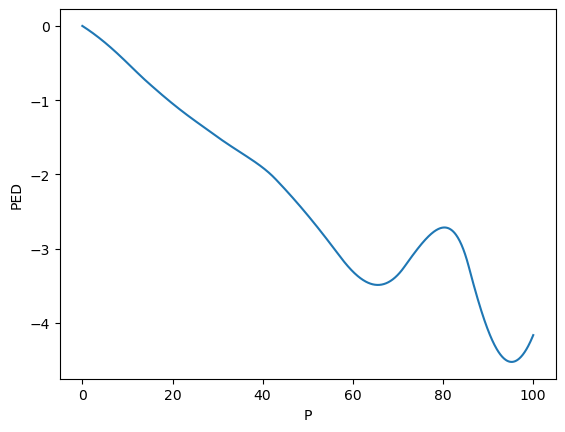

In [129]:
 ped_df \
    .plot(kind='line', x='P', y='PED', ylabel='PED') \
    .legend().remove()